**Homework 2**

**Gonçalo Meneses, 103401 e Tomás Arêde, 103239**

Começamos por carregar o nosso ficheiro arff e criar o data frame que irá armazenar os nossos dados.

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

data, col_names = arff.loadarff('column_diagnosis.arff')

df = pd.DataFrame(data)

df['class'] = df['class'].str.decode('utf-8')

df.columns = col_names.names()
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


**Exercício 1 (a)**

kNN Mean Accuracy: 0.8387096774193548
Naive Bayes Mean Accuracy: 0.8225806451612904


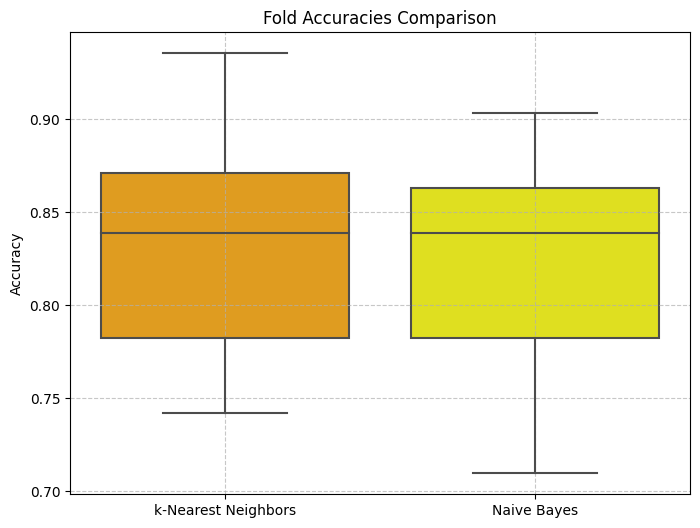

In [2]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop('class',axis=1)
y = df['class']

knn_classifier = KNeighborsClassifier(n_neighbors=5)
naiveb_classifier = GaussianNB()

strat_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

knn_score = cross_val_score(knn_classifier, X, y, cv=strat_cv)

naiveb_score = cross_val_score(naiveb_classifier, X, y, cv=strat_cv)

print("kNN Mean Accuracy:", np.mean(knn_score))
print("Naive Bayes Mean Accuracy:", np.mean(naiveb_score))

plt.figure(figsize=(8, 6))
sns.boxplot(data=[knn_score, naiveb_score], palette=['orange', 'yellow'])
plt.xticks([0, 1], ['k-Nearest Neighbors', 'Naive Bayes'])
plt.ylabel('Accuracy')
plt.title('Fold Accuracies Comparison')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

**Exercício 1 (b)**

In [3]:
from scipy import stats

t_stat, p_value = stats.ttest_rel(knn_score, naiveb_score, alternative="greater")

# Standard levels of significance
standard_alpha = [0.01, 0.05, 0.1]

print("Our p-value is:", p_value)

if any(p_value < alpha for alpha in standard_alpha):
    print("kNN is statistically superior to Naive Bayes regarding accuracy, for at least one of the standard levels of significance.")
else:
    print("There is no significant difference in accuracy between kNN and Naive Bayes, for the standard levels of significance.")

Our p-value is: 0.19042809062064092
There is no significant difference in accuracy between kNN and Naive Bayes, for the standard levels of significance.


**Exercício 2**

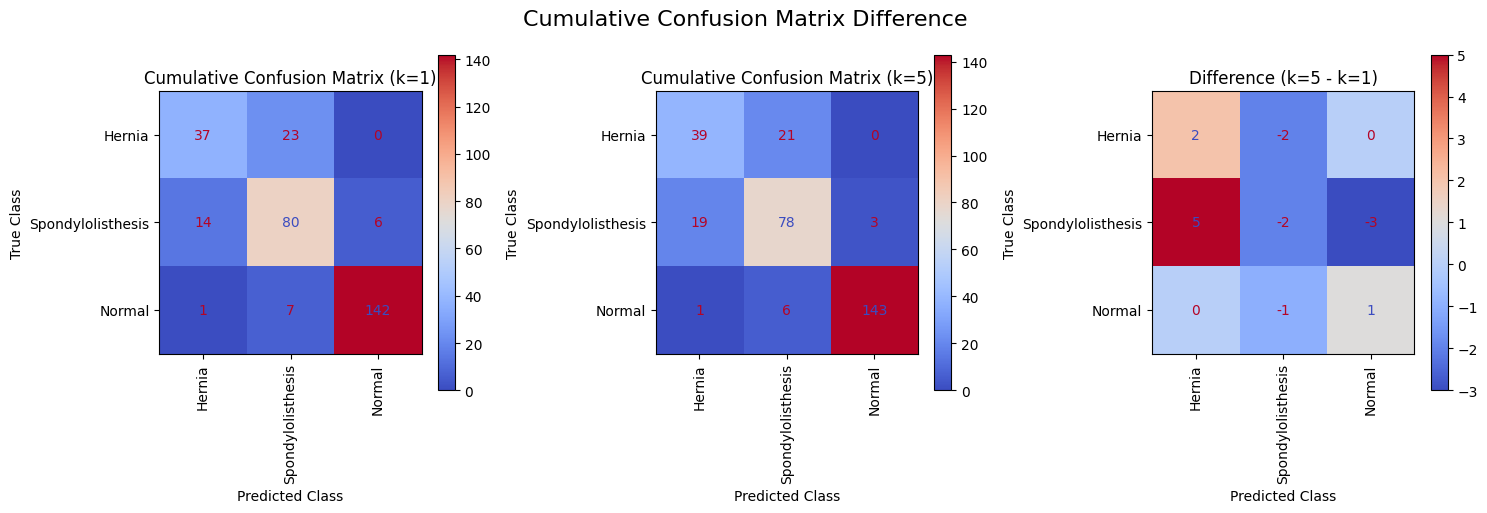

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

knn_1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean', weights='uniform')
knn_5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')

num_classes = len(np.unique(y))
class_names = df['class'].unique()

cumulative_conf_matrix_1 = np.zeros((num_classes, num_classes))
cumulative_conf_matrix_5 = np.zeros((num_classes, num_classes))

for train_ind, test_ind in strat_cv.split(X, y):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    knn_1.fit(X_train, y_train)
    knn_5.fit(X_train, y_train)

    y_pred_1 = knn_1.predict(X_test)
    y_pred_5 = knn_5.predict(X_test)

    conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
    conf_matrix_5 = confusion_matrix(y_test, y_pred_5)

    cumulative_conf_matrix_1 += conf_matrix_1
    cumulative_conf_matrix_5 += conf_matrix_5

conf_matrix_diff = cumulative_conf_matrix_5 - cumulative_conf_matrix_1

disp_1 = ConfusionMatrixDisplay(confusion_matrix=cumulative_conf_matrix_1.astype(int), display_labels=class_names)
disp_5 = ConfusionMatrixDisplay(confusion_matrix=cumulative_conf_matrix_5.astype(int), display_labels=class_names)
disp_diff = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_diff.astype(int), display_labels=class_names)

fig, axes = plt.subplots(1, 3, figsize=(15,5))

disp_1.plot(ax=axes[0], cmap='coolwarm', xticks_rotation='vertical', values_format='d')
axes[0].set_title("Cumulative Confusion Matrix (k=1)")
axes[0].set_xlabel("Predicted Class")
axes[0].set_ylabel("True Class")

disp_5.plot(ax=axes[1], cmap='coolwarm', xticks_rotation='vertical', values_format='d')
axes[1].set_title("Cumulative Confusion Matrix (k=5)")
axes[1].set_xlabel("Predicted Class")
axes[1].set_ylabel("True Class")

disp_diff.plot(ax=axes[2], cmap='coolwarm', xticks_rotation='vertical', values_format='d')
axes[2].set_title("Difference (k=5 - k=1)")
axes[2].set_xlabel("Predicted Class")
axes[2].set_ylabel("True Class")

plt.suptitle("Cumulative Confusion Matrix Difference", fontsize=16)
plt.tight_layout()
plt.show()

Como se pode ver no gráfico acima, as diferenças de desempenho entre os nossos dois predictors (k=1 e k=5) são relativamente pequenas, especialmente quando se considera a vasta gama de contagens (de 1 a 143). Especificamente, as diferenças registadas variam entre -5 e 3, o que representa apenas uma fração da variação global no conjunto de dados. Mesmo assim, é importante notar que o número de true positives aumenta para as classes Hernia (+2) e Normal (+1), diminuindo para a classe Spondylolisthesis (-2). Para além disso, é ainda observável uma diminuição do número de pessoas mal classificadas como Normal (-3) e Spondylolisthesis (-3), o que é compensado pelo aumento de pessoas mal classificadas como Hernia (+5). Por fim, podemos concluir que ambos os predictors apresentam uma precisão semelhante na previsão da classe do nosso conjunto de dados, devido à baixa dispersão dos mesmos.

**Exercício 3**

Algumas dificuldades do Naive Bayes que podem surgir quando se aprende com o conjunto de dados column_diagnosis começam com o pressuposto de independência, ou seja, todas as características podem não ser condicionalmente independentes, dada a classe. Outro problema importante é o facto de que, ao executar o Naive Bayes, estamos a assumir que as nossas variáveis de entrada seguem uma distribuição Normal perfeita, o que não é o caso, como vimos no homework 1, tal poderá dever-se ao número insuficiente de amostras do nosso dataset. Isto conduzirá a resultados não óptimos com o nosso classificador Naive Bayes. Por fim, os nossos resultados podem estar enviesados devido à presença relativamente grande de indivíduos classificados como Spondylolisthesis em comparação com indivíduos classificados como Hernia e Normal.